[*********************100%%**********************]  1 of 1 completed


Mean Squared Error: 8.601056786497818


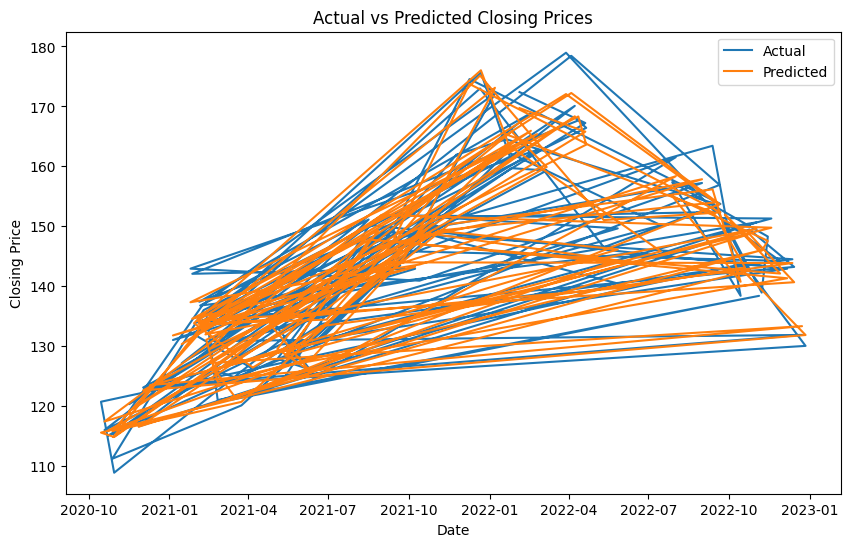

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Fetch historical data for a stock using yfinance
stock_data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')

# Feature engineering
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['SMA_200'] = stock_data['Close'].rolling(window=200).mean()
stock_data['Return'] = stock_data['Close'].pct_change()

# Drop rows with missing values
stock_data.dropna(inplace=True)

# Define features and target variable
X = stock_data[['SMA_50', 'SMA_200', 'Return']]
y = stock_data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
predictions = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, predictions, label='Predicted')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed


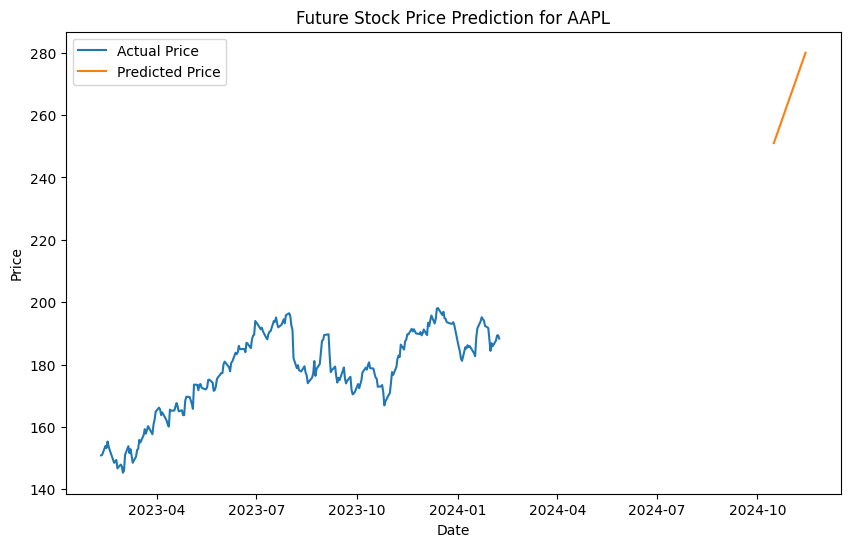

In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Function to predict future stock prices
def predict_stock(symbol, period, future_days):
    # Fetch historical data
    data = yf.download(symbol, period=period)

    # Extract features (only using 'Close' price for simplicity)
    X = np.array(data['Close']).reshape(-1, 1)
    y = np.array(data['Close'])

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make future predictions
    future_dates = np.arange(len(data['Close']), len(data['Close']) + future_days).reshape(-1, 1)
    future_predictions = model.predict(future_dates)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Close'], label='Actual Price')
    plt.plot(data.index[-1] + np.timedelta64(1, 'D') * future_dates, future_predictions, label='Predicted Price')
    plt.title('Future Stock Price Prediction for ' + symbol)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Example usage
predict_stock('AAPL', period='1y', future_days=30)


[*********************100%%**********************]  1 of 1 completed




Epoch 1/10

7/7 [==============================] - 5s 44ms/step - loss: 0.3105
Epoch 2/10
7/7 [==============================] - 0s 39ms/step - loss: 0.0452
Epoch 3/10
7/7 [==============================] - 0s 39ms/step - loss: 0.0170
Epoch 4/10
7/7 [==============================] - 0s 39ms/step - loss: 0.0214
Epoch 5/10
7/7 [==============================] - 0s 40ms/step - loss: 0.0105
Epoch 6/10
7/7 [==============================] - 0s 40ms/step - loss: 0.0121
Epoch 7/10
7/7 [==============================] - 0s 43ms/step - loss: 0.0098
Epoch 8/10
7/7 [==============================] - 0s 40ms/step - loss: 0.0102
Epoch 9/10
7/7 [==============================] - 0s 40ms/step - loss: 0.0097
Epoch 10/10
1/1 [==============================] - 0s 27ms/step


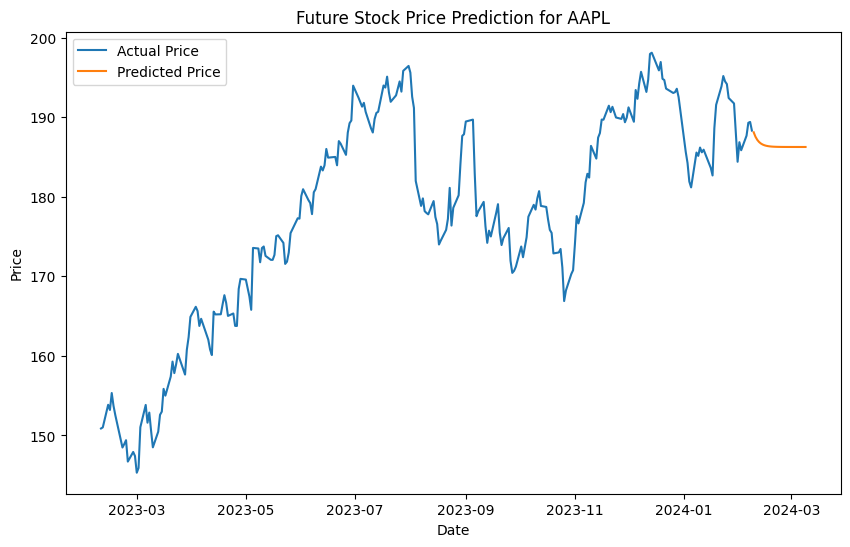

In [3]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Function to predict future stock prices using LSTM
def predict_stock_lstm(symbol, period, future_days):
    # Fetch historical data
    data = yf.download(symbol, period=period)

    # Prepare data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(np.array(data['Close']).reshape(-1, 1))

    # Create sequences and labels
    def create_sequences(data, sequence_length):
        X, y = [], []
        for i in range(len(data) - sequence_length - 1):
            X.append(data[i:(i + sequence_length), 0])
            y.append(data[i + sequence_length, 0])
        return np.array(X), np.array(y)

    sequence_length = 50
    X, y = create_sequences(scaled_data, sequence_length)

    # Split data into training and testing sets
    train_size = int(len(data) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape data for LSTM input (samples, time steps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train model
    model.fit(X_train, y_train, epochs=10, batch_size=32)

    # Make future predictions
    inputs = scaled_data[-sequence_length:]
    future_predictions = []
    for i in range(future_days):
        inputs = inputs.reshape(1, -1)
        inputs = np.expand_dims(inputs, axis=2)
        future_price = model.predict(inputs)
        future_predictions.append(future_price[0][0])
        inputs = np.roll(inputs, -1)
        inputs[-1] = future_price

    # Inverse transform the predictions
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Close'], label='Actual Price')
    future_dates = [data.index[-1] + pd.Timedelta(days=i) for i in range(1, future_days + 1)]
    plt.plot(future_dates, future_predictions, label='Predicted Price')
    plt.title('Future Stock Price Prediction for ' + symbol)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Example usage
predict_stock_lstm('AAPL', period='1y', future_days=30)


[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
7/7 [==============================] - 4s 39ms/step - loss: 0.3273
Epoch 2/10
7/7 [==============================] - 0s 38ms/step - loss: 0.0432
Epoch 3/10
7/7 [==============================] - 0s 39ms/step - loss: 0.0185
Epoch 4/10
7/7 [==============================] - 0s 38ms/step - loss: 0.0230
Epoch 5/10
7/7 [==============================] - 0s 39ms/step - loss: 0.0126
Epoch 6/10
7/7 [==============================] - 0s 41ms/step - loss: 0.0145
Epoch 7/10
7/7 [==============================] - 0s 43ms/step - loss: 0.0109
Epoch 8/10
7/7 [==============================] - 0s 41ms/step - loss: 0.0106
Epoch 9/10
7/7 [==============================] - 0s 41ms/step - loss: 0.0105
Epoch 10/10
1/1 [==============================] - 0s 29ms/step


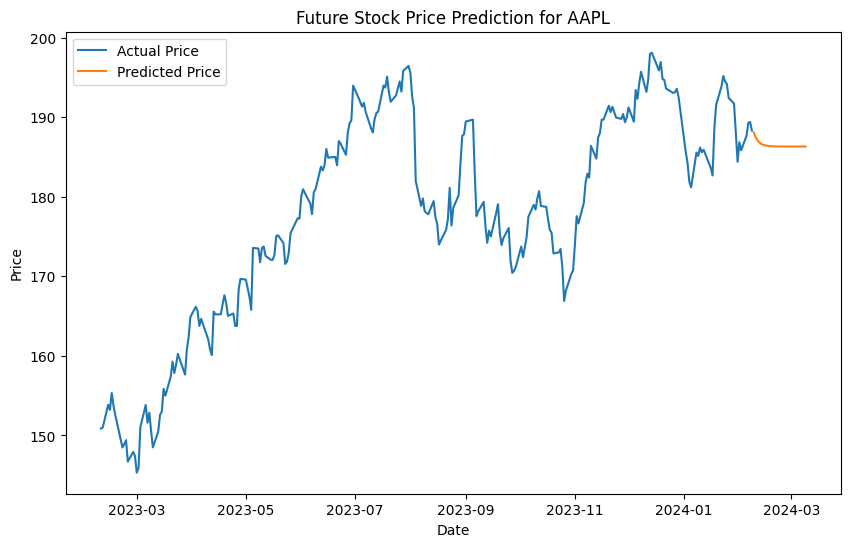

In [4]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Function to predict future stock prices using LSTM
def predict_stock_lstm(symbol, period):
    # Fetch historical data
    data = yf.download(symbol, period=period)

    # Prepare data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(np.array(data['Close']).reshape(-1, 1))

    # Create sequences and labels
    def create_sequences(data, sequence_length):
        X, y = [], []
        for i in range(len(data) - sequence_length - 1):
            X.append(data[i:(i + sequence_length), 0])
            y.append(data[i + sequence_length, 0])
        return np.array(X), np.array(y)

    sequence_length = 50
    X, y = create_sequences(scaled_data, sequence_length)

    # Split data into training and testing sets
    train_size = int(len(data) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape data for LSTM input (samples, time steps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train model
    model.fit(X_train, y_train, epochs=10, batch_size=32)

    # Make future predictions
    future_days = 30
    inputs = scaled_data[-sequence_length:]
    future_predictions = []
    for i in range(future_days):
        inputs = inputs.reshape(1, -1)
        inputs = np.expand_dims(inputs, axis=2)
        future_price = model.predict(inputs)
        future_predictions.append(future_price[0][0])
        inputs = np.roll(inputs, -1)
        inputs[-1] = future_price

    # Inverse transform the predictions
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Close'], label='Actual Price')
    future_dates = [data.index[-1] + pd.Timedelta(days=i) for i in range(1, future_days + 1)]
    plt.plot(future_dates, future_predictions, label='Predicted Price')
    plt.title('Future Stock Price Prediction for ' + symbol)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Example usage
predict_stock_lstm('AAPL', period='1y')
